In [1]:
import numpy as np
import sys
sys.path.insert(0,'../')
!cd ../../;make;cd python/test_deform_conv/
import caffe
print caffe

make: Nothing to be done for `all'.
<module 'caffe' from '../caffe/__init__.py'>


In [15]:
proto_str="""
force_backward: true
input: "data"
input_dim: 1
input_dim: 1
input_dim: 4
input_dim: 4
layer{
    name: "offset"
    type: "Convolution"
    bottom: "data"
    top: "offset"
    param{
        lr_mult: 1
        decay_mult: 1
    }
    param{
        lr_mult: 2
        decay_mult: 0
    }
    convolution_param{
        num_output: 32
        kernel_size: 2
        pad: 0
        stride: 2
        weight_filler{
            type: "constant"
            value: 0.0
        }
        bias_filler{
            type: "constant"
            value: 0
        }
    }
}
layer{
    name: "dconv"
    type: "DeformableConvolution"
#    type: "Convolution"
    bottom: "data"
    bottom: "offset"
    top: "dconv"
    param{
        lr_mult: 1
        decay_mult: 1
    }
    param{
        lr_mult: 2
        decay_mult: 0
    }
    convolution_param{
        num_output: 1
        kernel_size: 2
        pad: 0
        stride: 2
        weight_filler{
            type: "constant"
            value: 1
        }
        bias_filler{
            type: "constant"
            value: 0
        }
    }
    loss_weight: 1
}
"""
proto_file=open('deform_conv.prototxt','w')
proto_file.write(proto_str)
proto_file.close()

In [16]:
caffe.set_mode_gpu()
net = caffe.Net('deform_conv.prototxt', caffe.TEST)

In [17]:
data=net.blobs['data'].data
offset=net.blobs['offset'].data
dconv=net.blobs['dconv'].data
dweight=net.params['dconv'][0].data
dbias=net.params['dconv'][1].data

In [5]:
print 'data.shape:',data.shape
print 'offset.shape:',offset.shape
print 'dconv.shape:',dconv.shape
print 'dweight.shape:',dweight.shape
print 'dbias.shape:',dbias.shape

data.shape: (1, 1, 4, 4)
offset.shape: (1, 8, 2, 2)
dconv.shape: (1, 1, 2, 2)
dweight.shape: (1, 1, 2, 2)
dbias.shape: (1,)


In [6]:
data[:] = np.array([[[ [ 1, 2, 3, 4],
                       [ 4, 3, 2, 1],
                       [ 1, 2, 3, 4],
                       [ 4, 3, 2, 1]]]])
# data[:] = np.array([[[ [ 1, 1, 1, 1],
#                        [ 1, 1, 1, 1],
#                        [ 1, 1, 1, 1],
#                        [ 1, 1, 1, 1]]]])
# dweight[:]=np.array([[[ [ 1, 1],
#                        [ 1,1]]]])
print data
print dweight

[[[[ 1.  2.  3.  4.]
   [ 4.  3.  2.  1.]
   [ 1.  2.  3.  4.]
   [ 4.  3.  2.  1.]]]]
[[[[ 1.  1.]
   [ 1.  1.]]]]


In [7]:
net.forward()

{'dconv': array([[[[ 10.,  10.],
          [ 10.,  10.]]]], dtype=float32)}

In [8]:
print net.blobs['offset'].data

[[[[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]]]


In [9]:
net.backward()

{'data': array([[[[ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.]]]], dtype=float32)}

In [10]:
print net.params['dconv'][0].diff

[[[[  8.  12.]
   [ 12.   8.]]]]


In [11]:
print net.blobs['dconv'].diff
print net.blobs['data'].diff

[[[[ 1.  1.]
   [ 1.  1.]]]]
[[[[ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]


In [12]:
print net.blobs['offset'].diff

[[[[ 3. -1.]
   [ 3. -1.]]

  [[ 1.  1.]
   [ 1.  1.]]

  [[ 1. -3.]
   [ 1. -3.]]

  [[ 1.  0.]
   [ 1.  0.]]

  [[-3.  1.]
   [ 0.  0.]]

  [[-1. -1.]
   [-1. -1.]]

  [[-1.  3.]
   [ 0.  0.]]

  [[-1.  0.]
   [-1.  0.]]]]


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

[800, 1200, 400, 150]

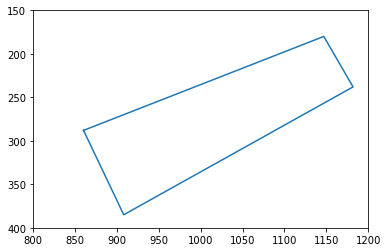

In [14]:
x=[860,1147,1182,908,860]
y=[288,180,238,385,288]
plt.plot(x,y)
plt.axis([800,1200,400,150])